## **SIFT + ANN (Max_keypoints and padding approach)**
#### **lr=1*10^(-6), epochs=400, Accuracy = 30% (approx) in (290, 300) epochs range**
#### **Test run - 1**

#### **Aim: To find suitable learning rate and epoch value.**

#### **For mounting drive**

In [1]:
#For mounting GDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Required modules**

In [2]:
#Req. opencv 4.5+
!pip uninstall opencv-python
!pip install opencv-python

Found existing installation: opencv-python 4.5.4.60
Uninstalling opencv-python-4.5.4.60:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.5.4.60.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Core-39545cc7.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Gui-ba0a2070.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Test-c38a5234.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5Widgets-e69d94fb.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libQt5XcbQpa-ca221f44.so.5.15.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libX11-xcb-69166bdf.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/di

In [3]:
#Importing necessary libraries
from zipfile import ZipFile
from tensorflow.python.client import device_lib
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
import cv2
import os
import sys
import numpy as np
import random

#### **Functions definition**

In [4]:
def extract_zip(file_name = "drive/MyDrive/Dataset_test_1.zip"):
    with ZipFile(file_name, "r") as zip:
        zip.extractall()
        print("Dataset Extracted")

In [5]:
def python_ver():
    print("\nPython version:\n")
    print(sys.version)

def device_info():
    print("\nDevice Info:\n")
    print(device_lib.list_local_devices())

def platform_info():
    print("\nPlatform Info:\n")
    print(platform.platform())
    print(platform.processor())

In [6]:
def SIFT_test(dirs, labels, img_size):
    """Scale Invariant Feature Transform Test run for finding the maximum keypoints detected among all the images in the dataset"""
    
    max_key = 0
    
    for data_dir in dirs:
        for label in labels:
            path = os.path.join(data_dir, label)
            for img in os.listdir(path):
                #Reading the image in grayscale mode
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                   
                #Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 

                #detecting keypoints
                sift = cv2.SIFT_create()
                keypoints = sift.detect(resized_arr, None)

                if (len(keypoints) > max_key):
                    max_key = len(keypoints)
                
    return max_key


In [7]:
def SIFT(image, max_key):
    """Scale Invariant Feature Transform for finding keypoints and computing descriptors"""
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    return np.pad(np.array(descriptors, dtype="i"), ((0, max_key-len(keypoints)), (0, 0)))[:max_key]

In [8]:
def dataset_creation(data_dir, labels, img_size, max_key):
    """Loading data and shuffling"""
    data = [] 

    for class_num, label in enumerate(labels): 
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            try:
                #Reading the image in grayscale mode
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                
                #Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 

                #SIFT function call
                SIFT_img_desc = SIFT(resized_arr, max_key)
                
                data.append([SIFT_img_desc, class_num])
            except Exception as err:
                print("Error:\n",err)
    
    random.shuffle(data)
    return np.array(data)

In [9]:
def dataset_creation_train_stat(labels, train):
    """Plot initial data graph"""
    list_graph = []
    for i in train:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))    
    sns.countplot(list_graph)
    plt.title("Train set")
    plt.show()


def dataset_creation_test_stat(labels, test):
    """Plot initial data graph"""
    list_graph = []
    for i in test:
        list_graph.append(labels[i[1]])
    
    sns.set_style('darkgrid')
    plt.figure(figsize=(25, 25))
    sns.countplot(list_graph)
    plt.title("Test set")
    plt.show()

In [10]:
def train_test_data_split(train, test):
    """train and test"""
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for feature, label in train:
        x_train.append(feature)
        y_train.append(label)

    for feature, label in test:
        x_test.append(feature)
        y_test.append(label)

    return (np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test))

In [11]:
def build_model_ann(tot_classes, x_train):
    """Builds ANN model and prints model summary"""
    model = Sequential()
    
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(3000,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1000,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(tot_classes, activation="softmax"))

    model.summary()
    return model

In [12]:
def compile_and_fit(model, x_train, y_train, x_test, y_test, iterations, l_rate):
    """Compiles and fits the model"""
    opt = Adam(learning_rate=l_rate)
    model.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
    history = model.fit(x_train, y_train, epochs = iterations, validation_data = (x_test, y_test))

    return (history, model)

In [13]:
def acc_plots(history, iterations):
    """Requires history and number of iterations"""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(iterations)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
def acc_results(model, labels, x_test, y_test):
    """Prediction and test accuracy"""
    predictions = np.argmax(model.predict(x_test), axis=-1)
    print(classification_report(y_test, predictions, target_names = labels))
    print("\nAccuracy = "+str(accuracy_score(y_test, predictions)*100)+"%")

#### **Making Function calls and defining variables**

In [15]:
#Extracting Dataset
extract_zip("drive/MyDrive/Dataset_test_1.zip")

#Device and environment Info
python_ver()
device_info()
platform_info()

Dataset Extracted

Python version:

3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

Device Info:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11229260222675314532
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11321147392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 141060554409236062
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]

Platform Info:

Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
x86_64


In [16]:
#Variables
dirs = ["Dataset_test_1/Train", "Dataset_test_1/Test"]
labels = ['Buddha', 'Garuda', 'Goddess_Durga', 'Goddess_Lakshmi', 'Goddess_Saraswathi', 'Lord_Ganesh', 
        'Lord_Hanuman', 'Lord_Hayagriva', 'Lord_Indra', 'Lord_Krishna', 'Lord_Muruga', 'Nandi', 'Nataraj', 
        'Shirdi_Sai_Baba', 'Shivling']
img_size = 224
tot_classes = len(labels)
num_sample_img = 3
iterations = 400
l_rate = 0.000001

In [17]:
#Max keypoints detection
max_key = SIFT_test(dirs, labels, img_size)

#Train and Test data loading
train = dataset_creation("Dataset_test_1/Train", labels, img_size, max_key)
test = dataset_creation("Dataset_test_1/Test", labels, img_size, max_key)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


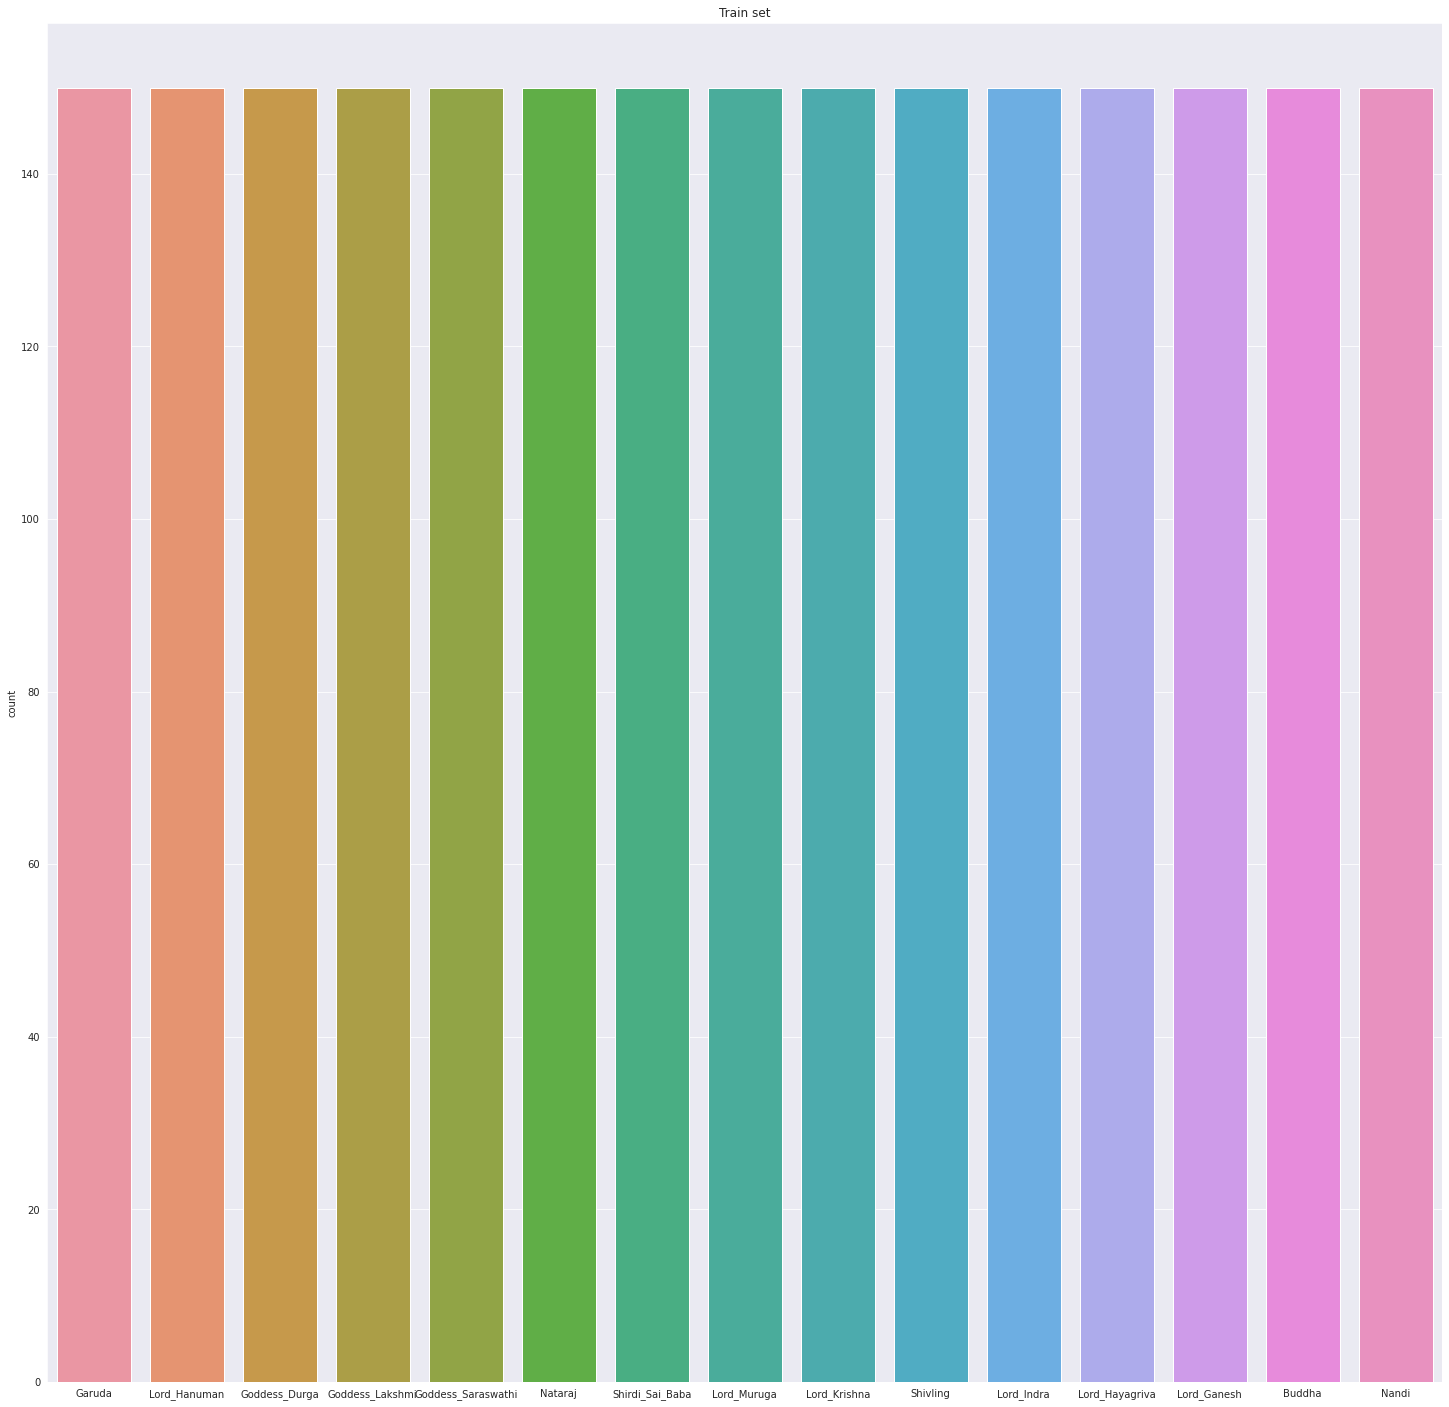

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


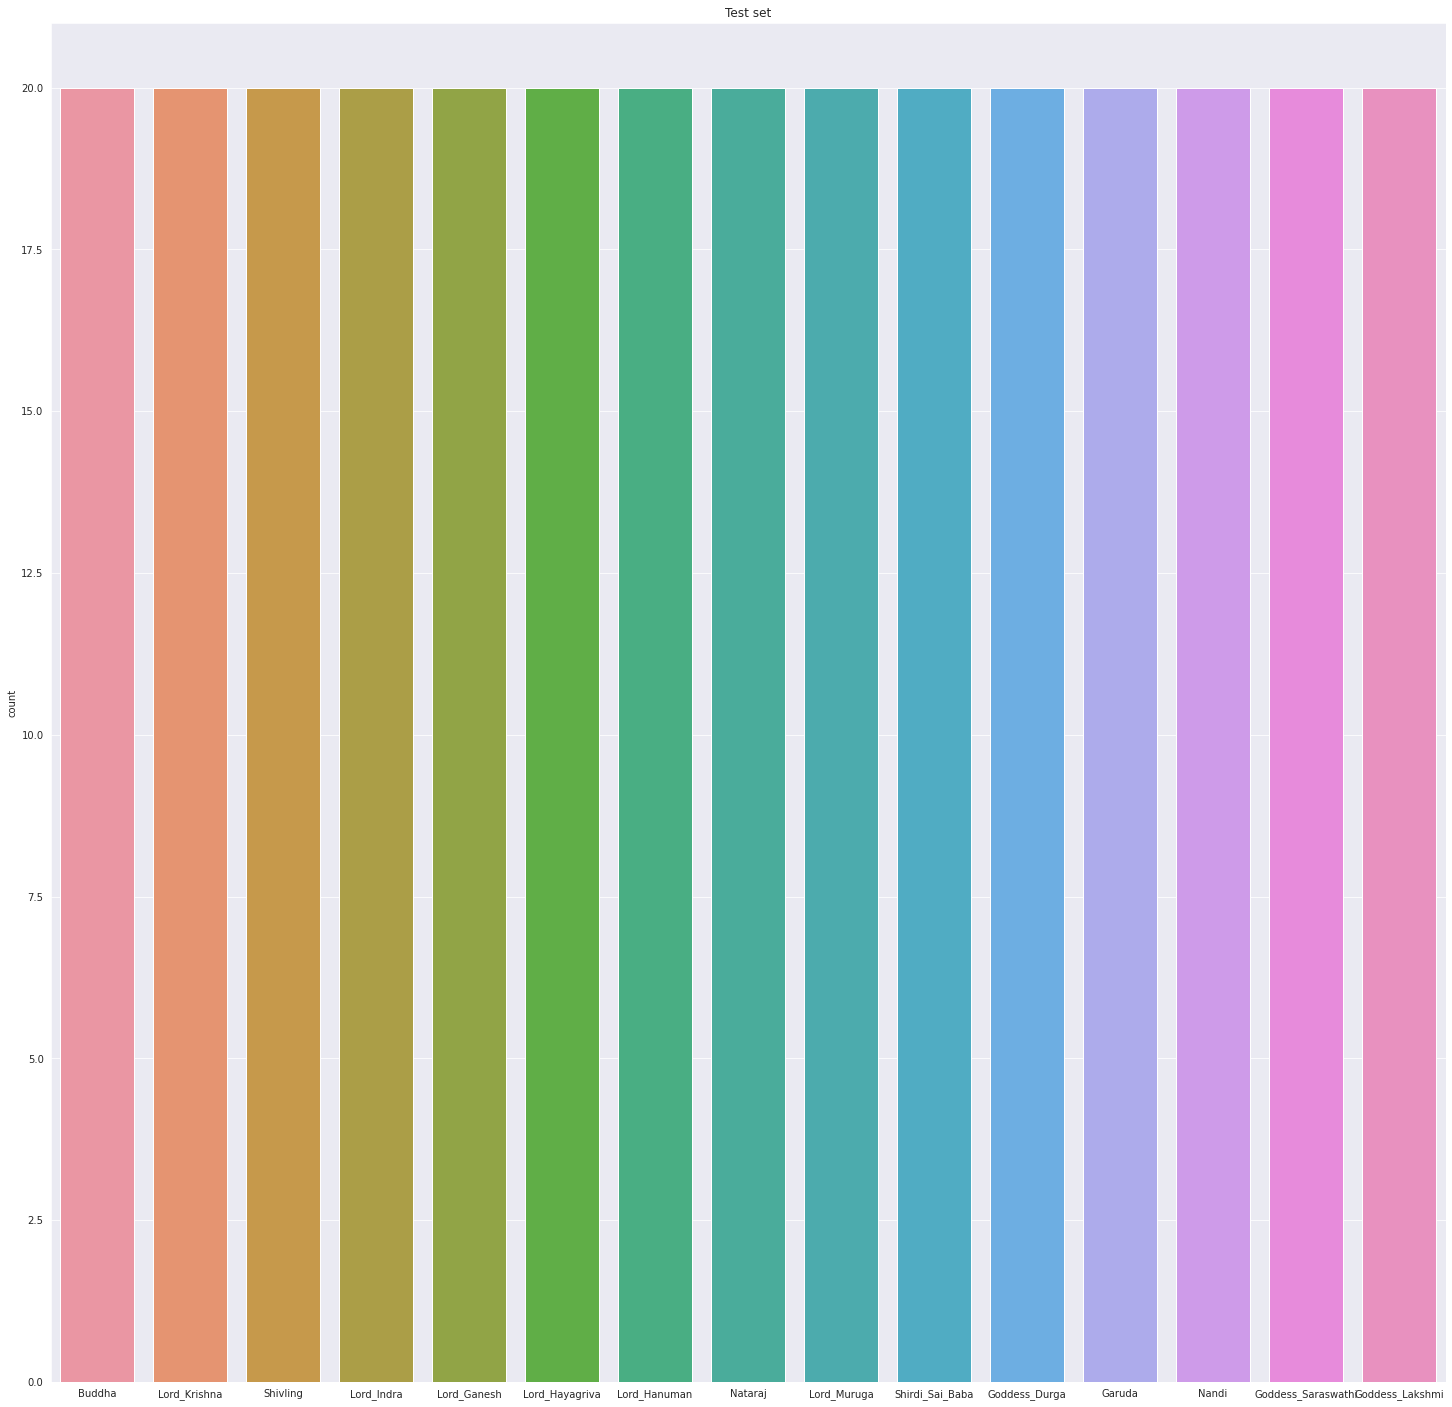

In [18]:
#Stats
dataset_creation_train_stat(labels, train)
dataset_creation_test_stat(labels, test)

In [19]:
#Training and testing data
x_train, y_train, x_test, y_test = train_test_data_split(train, test)

In [20]:
#Building ANN Model
model = build_model_ann(tot_classes, x_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 147712)            0         
                                                                 
 dense (Dense)               (None, 3000)              443139000 
                                                                 
 dropout (Dropout)           (None, 3000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              3001000   
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 15)                15015     
                                                                 
Total params: 446,155,015
Trainable params: 446,155,015


In [21]:
#Compile and fit the model
history, model = compile_and_fit(model, x_train, y_train, x_test, y_test, iterations, l_rate)

Epoch 1/400
71/71 [==============================] - 14s 186ms/step - loss: 86.2978 - accuracy: 0.0733 - val_loss: 26.8391 - val_accuracy: 0.1133
Epoch 2/400
71/71 [==============================] - 13s 183ms/step - loss: 66.3812 - accuracy: 0.0840 - val_loss: 21.7485 - val_accuracy: 0.1233
Epoch 3/400
71/71 [==============================] - 13s 182ms/step - loss: 54.7324 - accuracy: 0.0978 - val_loss: 19.7807 - val_accuracy: 0.1367
Epoch 4/400
71/71 [==============================] - 13s 181ms/step - loss: 48.4612 - accuracy: 0.1147 - val_loss: 17.5169 - val_accuracy: 0.1500
Epoch 5/400
71/71 [==============================] - 13s 182ms/step - loss: 40.8546 - accuracy: 0.1187 - val_loss: 16.5129 - val_accuracy: 0.1400
Epoch 6/400
71/71 [==============================] - 13s 180ms/step - loss: 36.1751 - accuracy: 0.1271 - val_loss: 14.9572 - val_accuracy: 0.1567
Epoch 7/400
71/71 [==============================] - 13s 181ms/step - loss: 31.5303 - accuracy: 0.1364 - val_loss: 13.7126 -

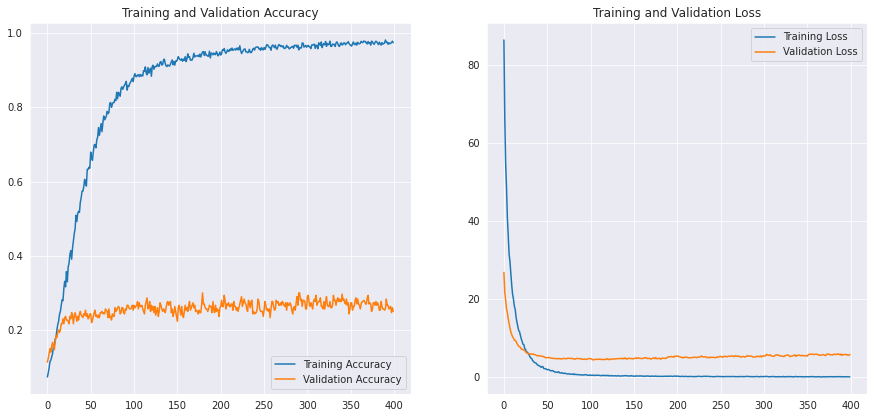

In [22]:
#Plots
acc_plots(history, iterations)

In [23]:
#Results
acc_results(model, labels, x_test, y_test)

                    precision    recall  f1-score   support

            Buddha       0.25      0.05      0.08        20
            Garuda       0.45      0.50      0.48        20
     Goddess_Durga       0.11      0.10      0.10        20
   Goddess_Lakshmi       0.13      0.15      0.14        20
Goddess_Saraswathi       0.09      0.10      0.09        20
       Lord_Ganesh       0.21      0.20      0.21        20
      Lord_Hanuman       0.12      0.10      0.11        20
    Lord_Hayagriva       0.12      0.05      0.07        20
        Lord_Indra       0.74      1.00      0.85        20
      Lord_Krishna       0.00      0.00      0.00        20
       Lord_Muruga       0.12      0.15      0.14        20
             Nandi       0.09      0.15      0.11        20
           Nataraj       0.37      0.50      0.43        20
   Shirdi_Sai_Baba       0.35      0.35      0.35        20
          Shivling       0.29      0.35      0.32        20

          accuracy                    

#### **Result: For learning rate = 1*10^(-6) and 400 iterations, the highest accuracy obtained is 30%(approx) in (290, 300).**